In [364]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 
from networkx.algorithms import bipartite
from networkx.algorithms import community
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import pygraphviz
from pylab import hist
from selenium import webdriver
from selenium.webdriver.common.by import By
import warnings
import hvplot.networkx as hvnx
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter('ignore')

In [135]:
link = 'https://www.allmusic.com/artist/metallica-mn0000446509/related'

In [218]:
driver = webdriver.Chrome('C:/Users/peter/Downloads/chromedriver_win32/chromedriver')  
driver.get(link)
time.sleep(3)
base_styles = driver.find_element_by_css_selector('div.styles')
list_styles = base_styles.find_elements_by_tag_name('a')

In [15]:
def Create_dataframe_givenURL(link):
    driver.get(link)
    time.sleep(3)
    related_base = driver.find_element_by_css_selector('section.related.influencers')
    name = driver.find_element_by_css_selector('h1.artist-name')
    lists = related_base.find_elements_by_tag_name('li')
    # GENRES
    base_styles = driver.find_element_by_css_selector('div.styles')
    list_styles = base_styles.find_elements_by_tag_name('a')
    genres = []
    for x in list_styles:
        genres.append(x.text)
    genre_list = ",".join(genres)
    liso = []
    for li in lists:
        base_element = li.find_element_by_tag_name('a')
        name_influenced = base_element.text
        linker = base_element.get_attribute('href')
        vals = np.array([name.text,name_influenced, linker, genre_list]).reshape(1,-1)
        liso.append(pd.DataFrame(vals, columns=['artist', 'influenced_by', 'link','genres']))
    df = pd.concat(liso)
    df.reset_index(inplace=True,drop=True)
    return df

In [217]:
def Create_nodes_givenURL(link):
    base_list = []
    driver.get(link)
    time.sleep(3)
    try:
        related_base = driver.find_element_by_css_selector('section.related.influencers')
    except:
        vals = np.array(['z','z', 'z','z']).reshape(1,-1)
        return pd.DataFrame(vals, columns=['artist', 'influenced_by', 'link','genres'])
    name = driver.find_element_by_css_selector('h1.artist-name')
    lists = related_base.find_elements_by_tag_name('li')
    liso = []
    # GENRES 
    base_styles = driver.find_element_by_css_selector('div.styles')
    list_styles = base_styles.find_elements_by_tag_name('a')
    genres = []
    for x in list_styles:
        genres.append(x.text)
    genre_list = ",".join(genres)
    if (len(lists) < 10):
        for li in lists:
            base_element = li.find_element_by_tag_name('a')
            name_influenced = base_element.text
            linker = base_element.get_attribute('href')
            vals = np.array([name.text,name_influenced, linker,genre_list]).reshape(1,-1)
            liso.append(pd.DataFrame(vals, columns=['artist', 'influenced_by', 'link','genres']))
        df = pd.concat(liso)
        df.reset_index(inplace=True,drop=True)
        return df
    else:
        for li in lists[0:10]:
            base_element = li.find_element_by_tag_name('a')
            name_influenced = base_element.text
            linker = base_element.get_attribute('href')
            vals = np.array([name.text,name_influenced, linker,genre_list]).reshape(1,-1)
            liso.append(pd.DataFrame(vals, columns=['artist', 'influenced_by', 'link', 'genres']))
        df = pd.concat(liso)
        df.reset_index(inplace=True,drop=True)
        return df

In [357]:
def GetListOfRecommendations(artist,df, G):
    c=nx.cliques_containing_node(G, nodes=artist)
    recommend = []
    artists = []
    for x in c:
        for item in x:
            if item == artist:
                continue
            else:
                if (item not in artists):
                    try:
                        genre = df[df['artist'] == item].genres.values[0]
                    except:
                        continue
                    recommend.append([item,genre])
                    artists.append(item)
    df1 = pd.DataFrame(recommend, columns=['artist','genre'])
    df1['base'] = artist
    G1 = nx.Graph()
    G1 = nx.from_pandas_edgelist(df1,source='base',target='artist')
    pos=nx.spring_layout(G1,k=0.15, iterations=20)
    return hvnx.draw_networkx(G1,pos,**options), df1

In [ ]:
# base = pd.read_csv('./BIG_Data.csv')
# g = pd.read_csv('./Data_Final.csv')
# small_df = pd.read_csv('./Metallica_Base284.csv')

In [17]:
df1 = Create_dataframe_givenURL(link)

In [ ]:
node_list = []
for x,y in df1.iterrows():
    node = Create_nodes_givenURL(y['link']+'/related')
    node_list.append(node)

In [ ]:
df = pd.concat(node_list)
df.reset_index(inplace=True,drop=True)

In [507]:
needs = []
for x in np.unique(df['influenced_by'].values):
    if x not in np.unique(df['artist'].values):
        url = df[df['influenced_by'] == x].values[0][2] + '/related'
        print(x)
        node = Create_nodes_givenURL(url)
        needs.append(node)
            

In [224]:
hh = pd.concat(needs)
hh.reset_index(inplace=True,drop=True)
hh.drop(hh[hh['artist'] == 'z'].index,inplace=True)
hh.reset_index(inplace=True,drop=True)

In [226]:
base = pd.concat([df,hh])
base.reset_index(inplace=True,drop=True)

In [ ]:
base_node_list = []
for x,y in base[base['artist'] == 'Metallica'].iterrows():
    base_node_list.append( y['influenced_by'] )

In [480]:
G = nx.Graph()
G = nx.from_pandas_edgelist(base,source='artist',target='influenced_by')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 682
Number of edges: 1957
Average degree:   5.7390


In [174]:
Gx = G.subgraph(base_node_list)
G_Base = G.subgraph(['Metallica'])

In [ ]:
options = {
    'node_color': 'red',
    'node_size': 100,
    'edge_width': 2,
    'width': 800,
    'height': 800,
    'arrows': False,
    'arrowstyle': 'simple',
    'arrowsize':5,
    'margins': 1
}
options_base = {
    'node_color': 'blue',
    'edge_color': 'blue',
    'node_size': 100,
    'edge_width': 2,
    'width': 1000,
    'height': 1000,
    'arrows': True,
    'arrowstyle': 'simple',
    'arrowsize':5
}

In [237]:
pos=nx.spring_layout(G,k=0.15, iterations=20)
hvnx.draw_networkx(G,pos,**options) *\
hvnx.draw_networkx_nodes(Gx,pos, node_color='blue', node_size = 200) *\
hvnx.draw_networkx_nodes(G_Base,pos, node_color='yellow', node_size=400)

:Overlay
   .Graph.I   :Graph   [start,end]
   .Graph.II  :Graph   [start,end]
   .Graph.III :Graph   [start,end]

In [75]:
pos=nx.spring_layout(G,k=0.15, iterations=20)
hvnx.draw_networkx(G,pos,**options) *\
hvnx.draw_networkx_nodes(Gx,pos, node_color='blue', node_size = 200) *\
hvnx.draw_networkx_nodes(G_Base,pos, node_color='yellow', node_size=400)

:Overlay
   .Graph.I   :Graph   [start,end]
   .Graph.II  :Graph   [start,end]
   .Graph.III :Graph   [start,end]

In [238]:
# CLIQUES
for n in G.nodes():
    c=nx.cliques_containing_node(G, nodes=n)
    print("%s belongs to cliques %s" %(n,c))
    
cliques=list(nx.find_cliques(G))
mapping={}
for n in G.nodes():
    if type(n)==str:
        for i,j in enumerate(cliques):
            mapping[i]="Clique of "+", ".join(j)
    if type(n)==int:
        for i,j in enumerate(cliques):
            mapping[i]="Clique of "+", ".join([str(jj) for jj in j])
            
Gclique=nx.make_max_clique_graph(G, create_using=None)
Gclique=nx.relabel_nodes(Gclique,mapping)

Metallica belongs to cliques [['Accept', 'Judas Priest', 'Metallica', 'Deep Purple'], ['Accept', 'Judas Priest', 'Metallica', 'Black Sabbath'], ['Accept', 'AC/DC', 'Metallica'], ['Accept', 'Iron Maiden', 'Metallica', 'Deep Purple'], ['Accept', 'Iron Maiden', 'Metallica', 'Black Sabbath'], ['Misfits', 'Motörhead', 'Black Sabbath', 'Metallica'], ['Misfits', 'Motörhead', 'Ramones', 'Metallica'], ['UFO', 'Deep Purple', 'Metallica', 'Led Zeppelin'], ['Saxon', 'Deep Purple', 'Metallica', 'Thin Lizzy'], ['Saxon', 'Black Sabbath', 'Metallica'], ['Killing Joke', 'Motörhead', 'Metallica', 'Black Sabbath'], ['Raven', 'Led Zeppelin', 'Deep Purple', 'Metallica', 'Judas Priest'], ['Raven', 'Led Zeppelin', 'Deep Purple', 'Metallica', 'Motörhead'], ['Raven', 'Led Zeppelin', 'Deep Purple', 'Metallica', 'Iron Maiden'], ['Raven', 'Black Sabbath', 'Metallica', 'Judas Priest'], ['Raven', 'Black Sabbath', 'Metallica', 'Motörhead'], ['Raven', 'Black Sabbath', 'Metallica', 'Iron Maiden'], ['Blitzkrieg', 'Meta

Led Zeppelin belongs to cliques [['Sonny Boy Williamson II', 'Willie Dixon', 'Led Zeppelin'], ['Sonny Boy Williamson II', "Howlin' Wolf", 'Led Zeppelin'], ['UFO', 'Deep Purple', 'Metallica', 'Led Zeppelin'], ['UFO', 'Jethro Tull', 'Led Zeppelin'], ['Anne Briggs', 'Led Zeppelin'], ['Danzig', 'Deep Purple', 'Led Zeppelin', 'Dio'], ['Danzig', 'Kiss', 'Led Zeppelin'], ['Danzig', 'Elvis Presley', 'Led Zeppelin'], ['Raven', 'Led Zeppelin', 'Deep Purple', 'Metallica', 'Judas Priest'], ['Raven', 'Led Zeppelin', 'Deep Purple', 'Metallica', 'Motörhead'], ['Raven', 'Led Zeppelin', 'Deep Purple', 'Metallica', 'Iron Maiden'], ['Raven', 'Led Zeppelin', 'Deep Purple', 'Van Halen'], ['Raven', 'Led Zeppelin', 'Kiss'], ['Blitzkrieg', 'Metallica', 'Deep Purple', 'Led Zeppelin'], ['Blitzkrieg', 'Metallica', 'AC/DC', 'Led Zeppelin'], ['Blitzkrieg', 'Kiss', 'Led Zeppelin'], ['Led Zeppelin', 'Willie Dixon', 'Muddy Waters'], ['Led Zeppelin', 'Samhain', 'Metallica'], ['Led Zeppelin', 'Deep Purple', 'Metallica'

New York Dolls belongs to cliques [['Sonny Boy Williamson II', 'The Rolling Stones', 'New York Dolls'], ['Sonny Boy Williamson II', 'New York Dolls', 'The Yardbirds'], ['Misfits', 'Kiss', 'New York Dolls'], ['Misfits', 'New York Dolls', 'MC5'], ['Misfits', 'New York Dolls', 'Sex Pistols', 'Ramones'], ['MC5', 'Chuck Berry', 'The Rolling Stones', 'New York Dolls'], ['New York Dolls', 'Archie Bell & the Drells'], ['New York Dolls', 'Chuck Berry', 'David Bowie', 'Sex Pistols'], ['New York Dolls', 'Chuck Berry', 'David Bowie', 'The Velvet Underground'], ['New York Dolls', 'Chuck Berry', 'The Yardbirds'], ['New York Dolls', 'Chuck Berry', 'Ramones', 'The Rolling Stones', 'T. Rex'], ['New York Dolls', 'Chuck Berry', 'Ramones', 'Sex Pistols'], ['New York Dolls', 'Sham 69', 'The Yardbirds'], ['New York Dolls', 'Sham 69', 'Sex Pistols', 'Ramones'], ['New York Dolls', 'Bo Diddley', 'The Rolling Stones'], ['New York Dolls', 'Bo Diddley', 'The Yardbirds']]
Sex Pistols belongs to cliques [['Misfits'

Free belongs to cliques [['Cream', 'Jimi Hendrix', 'Bad Company', 'Free', "Howlin' Wolf"], ['Cream', 'Jimi Hendrix', 'The Yardbirds', 'Free', "Howlin' Wolf"], ['Cream', 'B.B. King', 'The Yardbirds', 'Free'], ['Cream', 'Lynyrd Skynyrd', 'Free', 'Bad Company'], ['Cream', 'Lynyrd Skynyrd', 'Free', 'The Yardbirds'], ['AC/DC', 'The Who', 'Free', 'The Rolling Stones'], ['AC/DC', 'The Who', 'Free', 'The Kinks'], ['AC/DC', 'The Yardbirds', 'Free'], ['Lynyrd Skynyrd', 'The Rolling Stones', 'The Who', 'Free'], ['Lynyrd Skynyrd', 'Bad Company', 'The Who', 'Free'], ['The Rolling Stones', 'Alexis Korner', 'Free'], ['The Rolling Stones', 'Fleetwood Mac', 'Free'], ['B.B. King', 'Free', 'Fleetwood Mac', 'The Yardbirds'], ['Free', 'Bad Company', 'Fleetwood Mac']]
Small Faces belongs to cliques [['Humble Pie', 'Chuck Berry', 'Small Faces'], ['Brenda Holloway', 'Small Faces'], ['The Beatles', 'The Kinks', 'Small Faces', 'Pink Floyd'], ['The Beatles', 'The Kinks', 'Small Faces', 'Chuck Berry'], ['Irma Tho

Muddy Waters belongs to cliques [['Van Morrison', 'The Doors', 'Muddy Waters'], ['Jeff Beck', 'Buddy Guy', 'Muddy Waters'], ['Jeff Beck', 'Cream', 'Freddie King', 'Muddy Waters'], ['Big Bill Broonzy', 'Muddy Waters', 'Jackson C. Frank'], ['Big Bill Broonzy', 'Muddy Waters', 'Jimmy Rogers'], ['Big Bill Broonzy', 'Muddy Waters', 'Davy Graham'], ['Big Bill Broonzy', 'Muddy Waters', 'J.B. Hutto'], ['Big Bill Broonzy', 'Muddy Waters', 'Alexis Korner'], ['Frank Zappa', 'Muddy Waters'], ['Freddie King', 'Jimmy Rogers', 'Muddy Waters'], ['Freddie King', 'B.B. King', 'Muddy Waters', 'Cream'], ['Skip James', 'Alexis Korner', 'Muddy Waters'], ['Skip James', 'Cream', 'Muddy Waters'], ['The Doors', 'Willie Dixon', 'Muddy Waters'], ['The Doors', 'Muddy Waters', 'The Rolling Stones'], ['Led Zeppelin', 'Willie Dixon', 'Muddy Waters'], ['Led Zeppelin', 'Otis Rush', 'Muddy Waters'], ['Led Zeppelin', 'Chuck Berry', 'Muddy Waters'], ['Led Zeppelin', 'Jethro Tull', 'Muddy Waters'], ['John Mayall', 'Muddy W

Phil Spector belongs to cliques [['Nelson Riddle', 'Phil Spector'], ['Harold Bradley', 'Phil Spector'], ['The Beatles', 'Elvis Presley', 'Buddy Holly', 'Phil Spector'], ['The Beatles', 'The Beach Boys', 'Buddy Holly', 'Phil Spector'], ['The Beatles', 'The Beach Boys', 'Chuck Berry', 'Ramones', 'Phil Spector'], ['The Beatles', 'Phil Spector', 'Buffalo Springfield'], ['Chet Atkins', 'Phil Spector']]
The Beach Boys belongs to cliques [['Chubby Checker', 'Chuck Berry', 'The Beach Boys'], ['Dion', 'The Beach Boys'], ['The Beatles', 'The Beach Boys', 'Buddy Holly', 'Fleetwood Mac'], ['The Beatles', 'The Beach Boys', 'Buddy Holly', 'Phil Spector'], ['The Beatles', 'The Beach Boys', 'The Moody Blues', 'The Who'], ['The Beatles', 'The Beach Boys', 'Yes'], ['The Beatles', 'The Beach Boys', 'Chuck Berry', 'The Who'], ['The Beatles', 'The Beach Boys', 'Chuck Berry', 'Ramones', 'Phil Spector'], ['The Four Freshmen', 'The Beach Boys'], ['Frankie Lymon', 'The Beach Boys'], ['The Everly Brothers', 'Th

Woody Guthrie belongs to cliques [['Allen Ginsberg', 'Woody Guthrie', 'Bob Dylan'], ['Ewan MacColl', 'Ian & Sylvia', 'Woody Guthrie'], ['Woody Guthrie', 'Donovan', 'Davy Graham'], ['Woody Guthrie', 'Donovan', 'Bob Dylan'], ['Woody Guthrie', 'Grateful Dead', 'Bob Dylan']]
Allen Ginsberg belongs to cliques [['Allen Ginsberg', 'Woody Guthrie', 'Bob Dylan'], ['Allen Ginsberg', 'Jack Kerouac'], ['Allen Ginsberg', 'William Carlos Williams'], ['Allen Ginsberg', 'Walt Whitman'], ['Allen Ginsberg', 'William Blake'], ['Allen Ginsberg', 'Thelonious Monk'], ['Allen Ginsberg', 'Dizzy Gillespie'], ['Allen Ginsberg', 'Charlie Parker']]
Bill Monroe belongs to cliques [['Roscoe Holcomb', 'Bill Monroe'], ['Tommy Jarrell', 'Bill Monroe'], ['Gid Tanner & His Skillet Lickers', 'Bill Monroe'], ['Bill Monroe', 'The Delmore Brothers'], ['Bill Monroe', 'The Byrds', 'Bob Dylan'], ['Bill Monroe', 'Snuffy Jenkins'], ['Bill Monroe', 'Carl Perkins', 'Roy Acuff'], ['Bill Monroe', 'Carl Perkins', 'Jimmie Rodgers'], [

Dean Martin belongs to cliques [['Dean Martin', 'Bing Crosby'], ['Dean Martin', 'Al Jolson'], ['Dean Martin', 'The Mills Brothers'], ['Dean Martin', 'Nat King Cole'], ['Dean Martin', 'Jimmy Durante'], ['Dean Martin', 'Tex Ritter'], ['Dean Martin', 'Fats Waller'], ['Dean Martin', 'Elvis Presley'], ['Dean Martin', 'Louis Armstrong'], ['Dean Martin', 'Gene Autry'], ['Dean Martin', 'Fred Astaire']]
Lloyd Price belongs to cliques [['Dr. John', 'Lloyd Price'], ['Lloyd Price', 'Elvis Presley']]
Wynonie Harris belongs to cliques [['Wynonie Harris', 'Elvis Presley'], ['Wynonie Harris', 'Carl Perkins']]
Big Mama Thornton belongs to cliques [['Big Mama Thornton', 'Victoria Spivey'], ['Big Mama Thornton', 'Mamie Smith', 'Alberta Hunter'], ['Big Mama Thornton', 'Sippie Wallace'], ['Big Mama Thornton', 'Memphis Minnie'], ['Big Mama Thornton', 'Elvis Presley', 'Junior Parker'], ['Big Mama Thornton', 'Etta James', 'Ann Peebles'], ['Big Mama Thornton', 'Etta James', 'Janis Joplin', 'Alberta Hunter'], [

John Paul Jones belongs to cliques [['Charles Mingus', 'John Paul Jones'], ['Bill Black', 'John Paul Jones'], ['Geezer Butler', 'John Paul Jones'], ['Donald "Duck" Dunn', 'John Paul Jones'], ['Willie Dixon', 'John Paul Jones'], ['James Jamerson', 'John Paul Jones'], ['Jet Harris', 'John Paul Jones']]
Noel Redding belongs to cliques [['Geezer Butler', 'Noel Redding']]
Paul McCartney belongs to cliques [['Paul McCartney', 'Geezer Butler']]
Arthur Brown belongs to cliques [['James Brown', 'Little Richard', 'Arthur Brown'], ['James Brown', 'The Who', 'Arthur Brown'], ['The Beatles', 'Genesis', 'Arthur Brown'], ['The Beatles', 'Emerson, Lake & Palmer', 'Arthur Brown'], ['The Beatles', 'Arthur Brown', 'Little Richard'], ['The Beatles', 'Arthur Brown', 'Chuck Berry', 'The Who'], ['Liberace', 'Arthur Brown'], ['Billy Fury', 'Arthur Brown'], ["Screamin' Jay Hawkins", 'Arthur Brown'], ['Atomic Rooster', 'Genesis', 'Arthur Brown'], ['Atomic Rooster', 'Emerson, Lake & Palmer', 'Arthur Brown']]
Ato

Gene Vincent belongs to cliques [['Jeff Beck', 'Carl Perkins', 'Gene Vincent'], ['The Beatles', 'Carl Perkins', 'Gene Vincent'], ['The Beatles', 'Elvis Presley', 'Gene Vincent'], ['The Beatles', 'Gene Vincent', 'Little Richard'], ['The Beatles', 'Gene Vincent', 'Chuck Berry'], ['Bill Haley', 'Gene Vincent'], ['Hank Williams', 'Carl Perkins', 'Gene Vincent'], ['Hank Williams', 'Chuck Berry', 'Gene Vincent'], ['Hank Williams', 'Jerry Lee Lewis', 'Gene Vincent'], ['Johnny Burnette', 'Gene Vincent'], ['Jerry Lee Lewis', 'Gene Vincent', 'Johnny Kidd & the Pirates'], ['Johnny Kidd & the Pirates', 'Gene Vincent', 'Carl Perkins'], ['Johnny Kidd & the Pirates', 'Gene Vincent', 'Elvis Presley'], ['Johnny Kidd & the Pirates', 'Gene Vincent', 'Chuck Berry'], ['Benny Joy', 'Gene Vincent']]
Les Paul belongs to cliques [['Jeff Beck', 'Les Paul'], ['Chet Atkins', 'Les Paul']]
Buddy Holly belongs to cliques [['Gram Parsons', 'Hank Williams', 'Buddy Holly'], ['Gram Parsons', 'Elvis Presley', 'Buddy Holl

Dr. Feelgood belongs to cliques [['Eddie & the Hot Rods', 'Dr. Feelgood', 'The Damned', 'Sham 69'], ['Canned Heat', 'Dr. Feelgood'], ['John Lee Hooker', 'Dr. Feelgood', 'Bo Diddley'], ['Piano Red', 'Dr. Feelgood'], ['Dr. Feelgood', 'Johnny Kidd'], ['Dr. Feelgood', 'Sonny Boy Williamson I'], ['Dr. Feelgood', 'Muddy Waters', 'The Rolling Stones', 'Bo Diddley'], ['Dr. Feelgood', 'Muddy Waters', 'The Rolling Stones', 'Chuck Berry'], ['Dr. Feelgood', 'Muddy Waters', 'Willie Dixon']]
Eddie & the Hot Rods belongs to cliques [['Eddie & the Hot Rods', 'Dr. Feelgood', 'The Damned', 'Sham 69']]
Iggy Pop belongs to cliques [['The Doors', 'Iggy Pop', 'The Rolling Stones'], ['The Doors', 'Iggy Pop', "Howlin' Wolf"], ['The Doors', 'Iggy Pop', 'The Velvet Underground', 'Siouxsie and the Banshees', 'Bob Dylan'], ['Bob Dylan', 'Siouxsie and the Banshees', 'David Bowie', 'The Velvet Underground', 'Iggy Pop'], ['Suicide', 'Iggy Pop'], ['The Rolling Stones', 'The Who', 'Iggy Pop'], ['The 13th Floor Elevato

The Zombies belongs to cliques [['The Zombies', 'Vanilla Fudge']]
Leonard Caston belongs to cliques [['Leonard Caston', 'Willie Dixon']]
Little Brother Montgomery belongs to cliques [['Willie Dixon', 'Little Brother Montgomery']]
The Ink Spots belongs to cliques [['The Ink Spots', 'Clyde McPhatter'], ['The Ink Spots', 'Jackie Wilson'], ['The Ink Spots', 'Willie Dixon']]
The Mills Brothers belongs to cliques [['Dean Martin', 'The Mills Brothers'], ['The Mills Brothers', 'Jackie Wilson'], ['The Mills Brothers', 'Willie Dixon']]
Colosseum belongs to cliques [['Freddie King', 'Colosseum', 'Cream'], ['Jack Bruce', 'Colosseum', 'Graham Bond'], ['John Mayall', 'Colosseum', 'Cream'], ['Jimmy Smith', 'Colosseum'], ['Traffic', 'Colosseum'], ['Colosseum', 'Pink Floyd', 'Yes']]
Richie Havens belongs to cliques [['Richie Havens', 'Yes']]
Simon & Garfunkel belongs to cliques [['Simon & Garfunkel', 'Yes']]
Johnny Otis belongs to cliques [['Johnny Otis', '? & the Mysterians']]
Wilson Pickett belongs t

Eddie Lang belongs to cliques [['Eddie Lang', 'Bob Wills']]
Emmett Miller belongs to cliques [['Bob Wills', 'Emmett Miller'], ['Hank Williams', 'Emmett Miller']]
Joe Venuti belongs to cliques [['Bob Wills', 'Joe Venuti']]
Tommy Dorsey belongs to cliques [['Tommy Dorsey', 'Bob Wills']]
Cannon's Jug Stompers belongs to cliques [['Bob Wills', "Cannon's Jug Stompers"]]
Charlie Poole belongs to cliques [['Bob Wills', 'Charlie Poole']]
Booker T. Laury belongs to cliques [["Booker T. & the MG's", 'Booker T. Laury']]
Memphis Slim belongs to cliques [["Booker T. & the MG's", 'Memphis Slim'], ['Charles Brown', 'Memphis Slim']]
Rufus Thomas belongs to cliques [['Chubby Checker', 'Rufus Thomas'], ["Booker T. & the MG's", 'Rufus Thomas']]
Art Blakey belongs to cliques [["Booker T. & the MG's", 'Art Blakey']]
Big Jay McNeely belongs to cliques [["Booker T. & the MG's", 'Big Jay McNeely']]
Buddy Johnson belongs to cliques [['Buddy Johnson', "Booker T. & the MG's"]]
Eddie Floyd belongs to cliques [["B

James "Sugar Boy" Crawford belongs to cliques [['James "Sugar Boy" Crawford', 'Dr. John']]
Johnny Shines belongs to cliques [['Earl Hooker', 'Elmore James', 'Johnny Shines']]
James Burton belongs to cliques [['James Burton', 'Eddie Cochran']]
Mickey Baker belongs to cliques [['Eddie Cochran', 'Mickey Baker']]
The Mothers of Invention belongs to cliques [['The Mothers of Invention', 'Edgar Broughton Band']]
Albert Roussel belongs to cliques [['Albert Roussel', 'Edgard Varèse']]
Claude Debussy belongs to cliques [['Claude Debussy', 'Edgard Varèse']]
Richard Strauss belongs to cliques [['Richard Strauss', 'Edgard Varèse']]
Aaron Copland belongs to cliques [['Aaron Copland', 'Emerson, Lake & Palmer']]
Billy Wright belongs to cliques [['Etta James', 'Billy Wright']]
Sugar Pie DeSanto belongs to cliques [['Sugar Pie DeSanto', 'Etta James']]
The Midnighters belongs to cliques [['The Midnighters', 'Etta James']]
A.L. Lloyd belongs to cliques [['Ewan MacColl', 'A.L. Lloyd']]
Alan Bush belongs t

In [ ]:
G1, df = GetListOfRecommendations('Metallica',base,G)

In [518]:
all_genres = np.unique(base.genres.values).tolist()

In [382]:
# BASE GENRES FOR METALLICA
seperated_list_genre = base.iloc[0].genres.split(",")

In [399]:
sim_artists = []
base_artists = []
for genre in seperated_list_genre:
    for item in all_genres:
        if (genre in item):
            artist = base[base['genres'] == item].artist.values[0]
            sim_artists.append([artist,genre,item])
    

In [414]:
ll = []
liso = []
for x in sim_artists:
    if x[0] not in ll:
        ll.append(x[0])
        liso.append( [ x[0], x[1] ])

In [418]:
dups = pd.DataFrame(sim_artists,columns=['artist','genre','long_genre'])

In [508]:
len(dups)

117

In [509]:
len(dups[dups.duplicated(subset=['artist'])])

37

In [470]:
l = []
names = []
for x in dups.artist.value_counts().keys():
    count = dups.artist.value_counts().get(x)
    if count > 1:
        l.append(count)
        names.append(x)

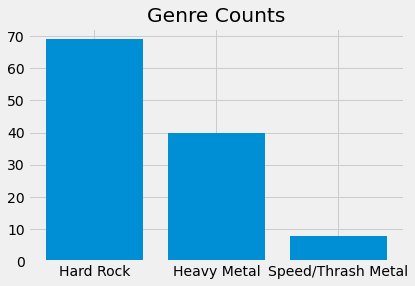

In [475]:
import matplotlib.pyplot as plt
x = dups.genre.value_counts()
plt.style.use('fivethirtyeight')
labs = ['Hard Rock','Heavy Metal','Speed/Thrash Metal']
plt.bar(labs,x)
plt.title("Genre Counts")
plt.show()

In [ ]:
G = nx.Graph()
G = nx.from_pandas_edgelist(g,source='artist',target='influenced_by')
print(nx.info(G))

In [77]:
pos = nx.layout.spring_layout(Gclique)  
hvnx.draw_networkx(Gclique, pos, **options) 

:Graph   [start,end]

In [ ]:
# CLIQUES
for n in G.nodes():
    c=nx.cliques_containing_node(G, nodes=n)
    print("%s belongs to cliques %s" %(n,c))
    
cliques=list(nx.find_cliques(G))
mapping={}
for n in G.nodes():
    if type(n)==str:
        for i,j in enumerate(cliques):
            mapping[i]="Clique of "+", ".join(j)
    if type(n)==int:
        for i,j in enumerate(cliques):
            mapping[i]="Clique of "+", ".join([str(jj) for jj in j])
            
Gclique=nx.make_max_clique_graph(G, create_using=None)
Gclique=nx.relabel_nodes(Gclique,mapping)

In [239]:
pos = nx.layout.spring_layout(Gclique)  
hvnx.draw_networkx(Gclique, pos, **options) 

:Graph   [start,end]